In [1]:
import os
import pandas as pd
import glob
import pandas as pd
import matplotlib.pyplot as plt
import random
from matplotlib.dates import DateFormatter, HourLocator
from matplotlib.dates import DateFormatter, HourLocator, MonthLocator

In [2]:
def calculate_daily_medians(df):
    """
    Calculate daily LMP medians for each zone from the original dataframe.
    
    Parameters:
    df (DataFrame): The original dataframe containing LMP data
    
    Returns:
    DataFrame: A dataframe with daily medians for each zone
    """
    # ensure Date is in datetime format
    if not pd.api.types.is_datetime64_any_dtype(df['Date']):
        df['Date'] = pd.to_datetime(df['Date'])
    
    # extract day from the Date column
    df_with_day = df.copy()
    df_with_day['Day'] = df_with_day['Date'].dt.date
    
    # group by Day and Zone, calculate the median LMP
    daily_median = df_with_day.groupby(['Day', 'Zone'])['LMP'].median().reset_index()
    
    # convert Day back to datetime for easier processing
    daily_median['Date'] = pd.to_datetime(daily_median['Day'])
    
    # add Year and Month columns
    daily_median['Year'] = daily_median['Date'].dt.year
    daily_median['Month'] = daily_median['Date'].dt.month
    
    return daily_median

In [3]:
def calculate_monthly_medians(daily_median_df):
    """
    Calculate monthly LMP medians for each zone from a daily medians dataframe.
    
    Parameters:
    daily_median_df (DataFrame): The dataframe with daily medians
    
    Returns:
    DataFrame: A dataframe with monthly medians for each zone
    """
    # create a copy as mentioned
    df_with_day = daily_median_df.copy()
    
    # group by Year, Month, and Zone to get monthly medians
    monthly_median = daily_median_df.groupby(['Year', 'Month', 'Zone'])['LMP'].median().reset_index()
    
    # create a proper Date column for the first day of each month
    monthly_median['Date'] = pd.to_datetime(monthly_median[['Year', 'Month']].assign(day=1))
    
    # add month name for better readability
    monthly_median['Month_Name'] = monthly_median['Date'].dt.strftime('%b')
    
    return monthly_median

In [4]:
def plot_hourly_data(ax, day_df, day_date, zone):
    """Plot hourly LMP data for a specific day"""
    ax.plot(day_df['Date'], day_df['LMP'], linestyle='-', color='blue')
    
    # format the subplot
    day_date_str = day_date.strftime('%B %d, %Y')
    ax.set_title(f"Hourly LMP Prices for Zone {zone} on {day_date_str}", fontsize=14)
    ax.set_xlabel("Time of Day", fontsize=12)
    ax.set_ylabel("LMP ($/MWh)", fontsize=12)
    ax.grid(True, alpha=0.3)
    
    # format x-axis to show hours
    hour_locator = HourLocator(interval=1)
    ax.xaxis.set_major_locator(hour_locator)
    ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
    plt.setp(ax.get_xticklabels(), rotation=45)
    
    # add day median line
    day_median = day_df['LMP'].median()
    ax.axhline(y=day_median, color='r', linestyle='--', alpha=0.7, 
              label=f'Day Median: ${day_median:.2f}/MWh')
    ax.legend()
    
    return day_median

In [5]:
def plot_daily_medians(ax, daily_median, month_name, year, zone, random_day=None):
    """Plot daily median LMP data for a specific month"""
    ax.plot(pd.to_datetime(daily_median['Day']), daily_median['LMP'], 
           marker='o', linestyle='-', color='green', label='Daily Median LMP')
    
    # calculate and add monthly median line
    monthly_median = daily_median['LMP'].median()
    ax.axhline(y=monthly_median, color='r', linestyle='--', alpha=0.7, 
              label=f'Monthly Median: ${monthly_median:.2f}/MWh')
    
    # format the subplot
    ax.set_title(f"Daily Median LMP Prices for Zone {zone} in {month_name} {year}", fontsize=14)
    ax.set_xlabel("Date", fontsize=12)
    ax.set_ylabel("LMP ($/MWh)", fontsize=12)
    ax.grid(True, alpha=0.3)
    
    # format x-axis to show dates properly
    ax.xaxis.set_major_formatter(DateFormatter('%d-%b'))
    plt.setp(ax.get_xticklabels(), rotation=45)
    
    # only label the random day we picked (if provided)
    if random_day is not None:
        for day, lmp in zip(pd.to_datetime(daily_median['Day']), daily_median['LMP']):
            if day.date() == random_day:
                ax.text(day, lmp + 0.8, f'${lmp:.2f}', ha='center', fontsize=10)
                # highlight this point
                ax.plot(day, lmp, 'ro', markersize=8)
    
    ax.legend()
    
    return monthly_median

In [6]:
def plot_monthly_medians(ax, monthly_median_df, year, zone, random_month=None):
    """Plot monthly median LMP data for a specific year"""
    ax.plot(monthly_median_df['Date'], monthly_median_df['LMP'], 
           marker='s', linestyle='-', color='purple', label='Monthly Median LMP')
    
    # calculate and add yearly median line
    yearly_median = monthly_median_df['LMP'].median()
    ax.axhline(y=yearly_median, color='r', linestyle='--', alpha=0.7, 
              label=f'Yearly Median: ${yearly_median:.2f}/MWh')
    
    # format the subplot
    ax.set_title(f"Monthly Median LMP Prices for Zone {zone} in {year}", fontsize=14)
    ax.set_xlabel("Month", fontsize=12)
    ax.set_ylabel("LMP ($/MWh)", fontsize=12)
    ax.grid(True, alpha=0.3)
    
    # format x-axis to show month names
    ax.xaxis.set_major_formatter(DateFormatter('%b'))
    plt.setp(ax.get_xticklabels(), rotation=45)
    
    # only label the random month we picked (if provided)
    if random_month is not None:
        for date, lmp in zip(monthly_median_df['Date'], monthly_median_df['LMP']):
            if date.month == random_month:
                ax.text(date, lmp + 0.8, f'${lmp:.2f}', ha='center', fontsize=10)
                # highlight this point
                ax.plot(date, lmp, 'ro', markersize=8)
    
    ax.legend()
    
    return yearly_median

In [24]:
def sample_analysis(df, zone="PECO", year=2018):
    """
    Perform a comprehensive sample analysis of LMP data for a specific zone and year.
    Selects a random month and day to analyze at different time scales.
    
    Parameters:
    df (DataFrame): The original dataframe containing LMP data
    zone (str): The zone to filter for
    year (int): The year to filter for
    
    Returns:
    Tuple: (daily_median_df, monthly_median_df, yearly_stats, fig)
    """
    # convert year to int to ensure proper comparison
    year = int(year)
    
    # create a copy of the dataframe for filtering
    df_copy = df.copy()
    
    # ensure Date is in datetime format
    if not pd.api.types.is_datetime64_any_dtype(df_copy['Date']):
        df_copy['Date'] = pd.to_datetime(df_copy['Date'])
    
    # extract year for filtering
    df_copy['Year'] = df_copy['Date'].dt.year
    df_copy['Month'] = df_copy['Date'].dt.month
    df_copy['Day'] = df_copy['Date'].dt.date
    
    # filter for the specified zone and year
    filtered_df = df_copy[(df_copy['Zone'] == zone) & (df_copy['Year'] == year)]
    
    # check if we have data after filtering
    if filtered_df.empty:
        print(f"No data found for Zone '{zone}' in Year {year}")
        return None, None, None, None
    
    # calculate daily medians for the entire year
    daily_median_year = calculate_daily_medians(filtered_df)
    
    # calculate monthly medians for the entire year
    monthly_median_year = calculate_monthly_medians(daily_median_year)
    
    # get available months in this year/zone
    available_months = sorted(filtered_df['Month'].unique())
    
    if not available_months:
        print(f"No monthly data found for Zone '{zone}' in Year {year}")
        return None, None, None, None
    
    # pick a random month
    random_month = random.choice(available_months)
    month_name = pd.to_datetime(f"{year}-{random_month}-01").strftime('%B')
    
    # filter for the random month
    month_df = filtered_df[filtered_df['Month'] == random_month]
    
    # calculate daily medians for the selected month
    daily_median_month = daily_median_year[daily_median_year['Month'] == random_month]
    
    # pick a random day from the month for hourly analysis
    available_days = sorted(month_df['Day'].unique())
    if not available_days:
        print(f"No daily data found for Zone '{zone}' in {month_name} {year}")
        return daily_median_month, monthly_median_year, None, None
    
    random_day = random.choice(available_days)
    day_df = month_df[month_df['Day'] == random_day]
    day_df = day_df.sort_values('Date')
    
    # create a figure with three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 15), 
                                       gridspec_kw={'height_ratios': [1, 1, 1]})
    
    # subplot 1: hourly LMP prices for the random day
    day_median = plot_hourly_data(ax1, day_df, random_day, zone)
    
    # subplot 2: daily medians for the random month
    monthly_median = plot_daily_medians(ax2, daily_median_month, month_name, year, zone, random_day)
    
    # subplot 3: monthly medians for the year
    yearly_median = plot_monthly_medians(ax3, monthly_median_year, year, zone, random_month)
    
    plt.tight_layout()

In [8]:
def post_process_daily_medians(daily_df):
    # create a copy to avoid modifying the original
    df = daily_df.copy()
    
    # create a mapping for zone names
    zone_mapping = {
        'APS': 'Allegheny Power',
        'DUQ': 'Duquesne Light',
        'METED': 'Met Ed',
        'PECO': 'PECO Energy',
        'PENELEC': 'Penelec',
        'PPL': 'PPL Electric Utilities'
    }
    
    # replace zone names
    df['Zone'] = df['Zone'].replace(zone_mapping)
    
    # rename columns
    df = df.rename(columns={
        'Date': 'created_at',
        'LMP': 'lmp',
        'Zone': 'utility_name' 
    })
    
    # drop columns
    columns_to_drop = ['Year','Day','Month']
    df = df.drop(columns=columns_to_drop)
    
    return df

In [9]:
def post_process_monthly_medians(monthly_df):
    # create a copy to avoid modifying the original
    df = monthly_df.copy()
    
    # create a mapping for zone names
    zone_mapping = {
        'APS': 'Allegheny Power',
        'DUQ': 'Duquesne Light',
        'METED': 'Met Ed',
        'PECO': 'PECO Energy',
        'PENELEC': 'Penelec',
        'PPL': 'PPL Electric Utilities'
    }
    
    # replace zone names
    df['Zone'] = df['Zone'].replace(zone_mapping)
    
    # rename columns
    df = df.rename(columns={
        'Date': 'created_at',
        'LMP': 'lmp',
        'Zone': 'utility_name' 
    })
    
    # drop columns
    columns_to_drop = ['Year', 'Month_Name','Month']
    df = df.drop(columns=columns_to_drop)
    
    return df

In [10]:
current_dir = os.getcwd()
print(f"Starting directory: {current_dir}")

# years to process
years = [2017, 2018, 2019, 2020, 2021, 2022, 2023]

# empty list to store dataframes from each year
all_dfs = []

Starting directory: /home/jupyter-noz224/Lamadrid Research


In [11]:
for year in years:
    year_dir = str(year)
    
    try:
        os.chdir(os.path.join(current_dir, year_dir))
        print(f"Processing directory: {os.getcwd()}")
        
        # find all CSV files in the directory
        csv_files = glob.glob("*.csv")
        
        if not csv_files:
            print(f"No CSV files found in {year_dir} directory")
            continue
        
        # read each CSV file and add to the list
        for csv_file in csv_files:
            
            df = pd.read_csv(csv_file)
            
            # add a Year column for tracking
            df['File_Year'] = year
            df['Source_File'] = csv_file
            
            # append to our list of dataframes
            all_dfs.append(df)
            
            print(f"Added {len(df)} rows from {csv_file}")
        
    except FileNotFoundError:
        print(f"Directory {year_dir} not found, skipping")
    except Exception as e:
        print(f"Error processing {year_dir}: {str(e)}")
    finally:
        # always return to the original directory
        os.chdir(current_dir)

# combine all dataframes into a single dataframe
if all_dfs:
    combined_df = pd.concat(all_dfs, ignore_index=True)
    print("\nCombined dataframe created successfully")
else:
    print("No data was processed")

Processing directory: /home/jupyter-noz224/Lamadrid Research/2017
Added 6589102 rows from APS2017.csv
Added 4172425 rows from PPL2017.csv
Added 861091 rows from DUQ2017.csv
Added 2100759 rows from METED2017.csv
Added 2809213 rows from PECO2017.csv
Added 3025857 rows from PENELEC2017.csv
Processing directory: /home/jupyter-noz224/Lamadrid Research/2018
Added 4149961 rows from PPL2018.csv
Added 6190878 rows from APS2018.csv
Added 2034390 rows from METED2018.csv
Added 831235 rows from DUQ2018.csv
Added 2890224 rows from PENELEC2018.csv
Added 2718834 rows from PECO2018.csv
Processing directory: /home/jupyter-noz224/Lamadrid Research/2019
Added 5432187 rows from APS2019.csv
Added 3839245 rows from PPL2019.csv
Added 1815250 rows from METED2019.csv
Added 719811 rows from DUQ2019.csv
Added 2547064 rows from PENELEC2019.csv
Added 2334103 rows from PECO2019.csv
Processing directory: /home/jupyter-noz224/Lamadrid Research/2020
Added 3006707 rows from PENELEC2020.csv
Added 2676346 rows from PECO20

In [12]:
combined_df['Date'] = pd.to_datetime(combined_df['Date'])

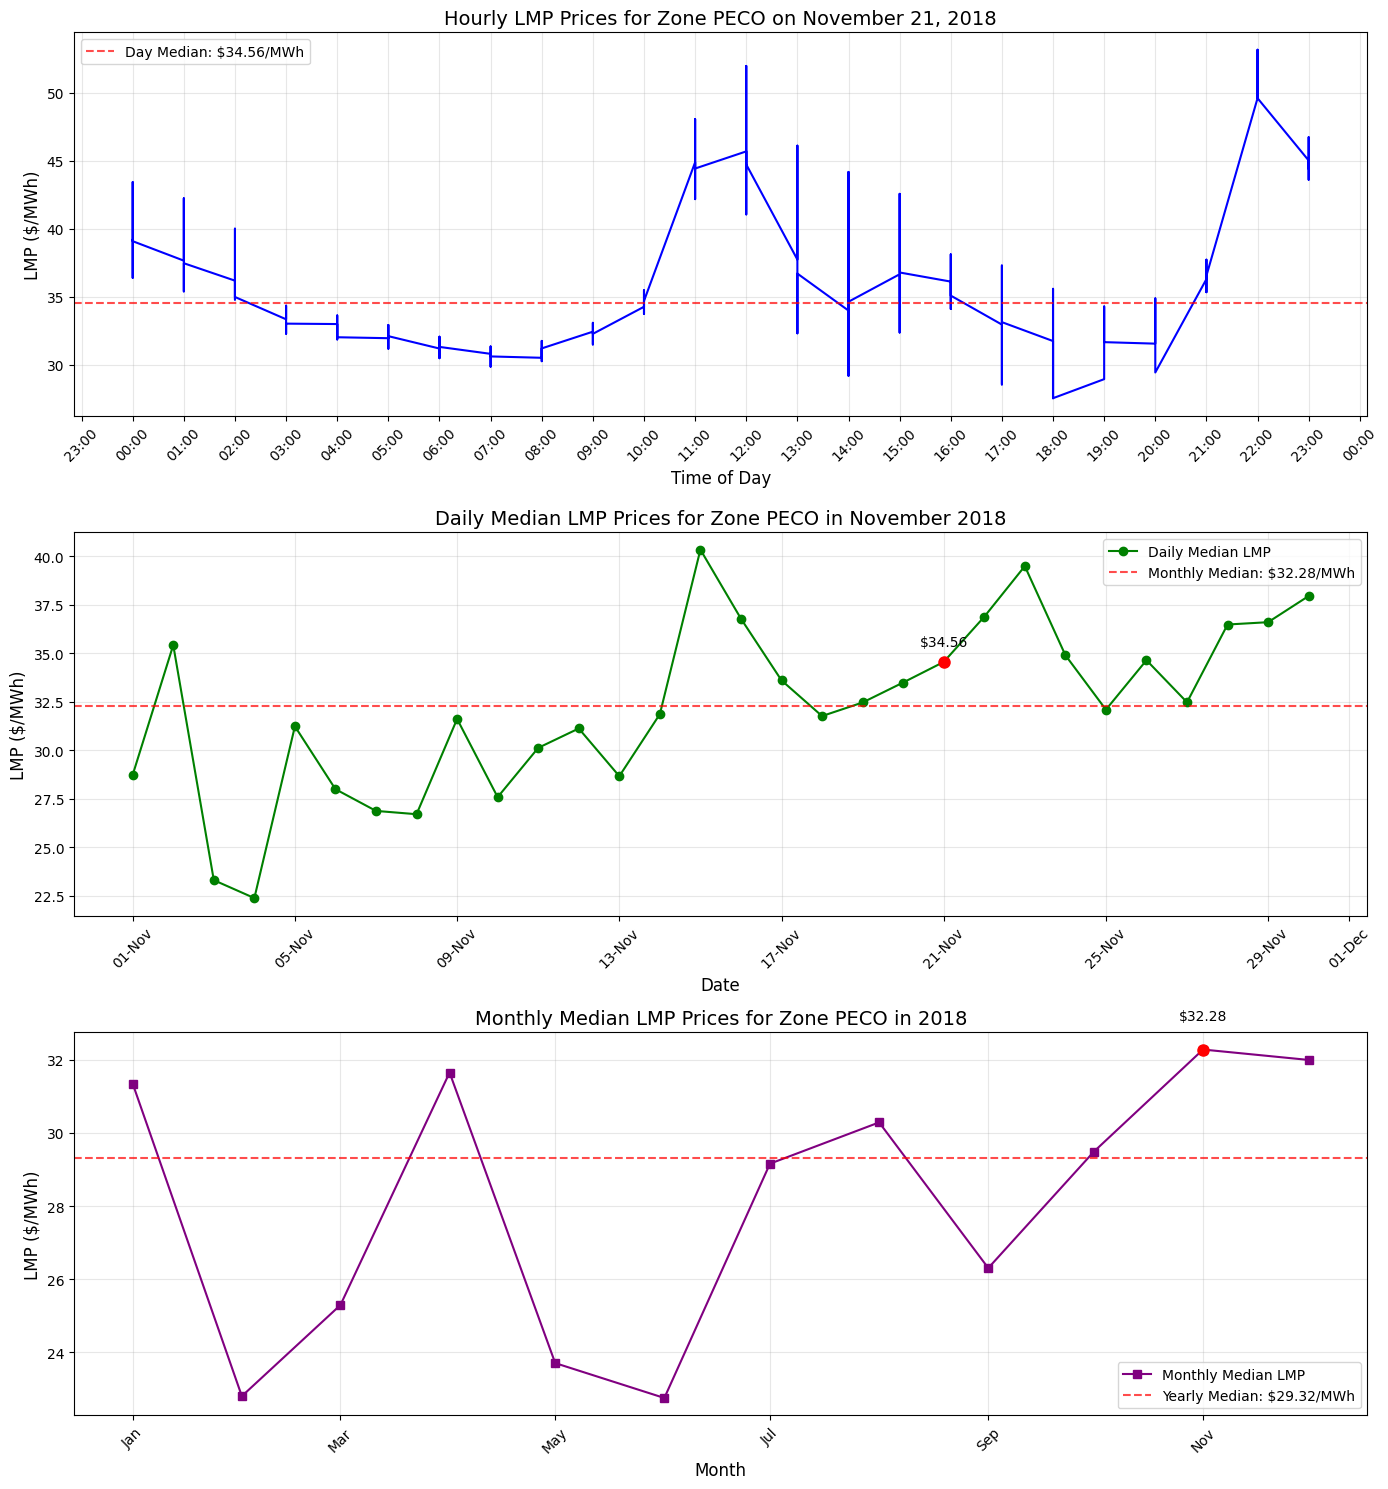

In [25]:
# sample analsis for the dataset
sample_analysis(combined_df)

In [14]:
# calculate daily medians for the entire dataset
df_daily_median = calculate_daily_medians(combined_df)

In [15]:
df_daily_median 

,Day,Zone,LMP,Date,Year,Month
0,2017-01-01,APS,25.86,2017-01-01,2017,1
1,2017-01-01,DUQ,24.87,2017-01-01,2017,1
2,2017-01-01,METED,25.15,2017-01-01,2017,1
3,2017-01-01,PECO,25.05,2017-01-01,2017,1
4,2017-01-01,PENELEC,24.68,2017-01-01,2017,1
...,...,...,...,...,...,...
14305,2024-01-01,DUQ,20.96,2024-01-01,2024,1
14306,2024-01-01,METED,20.79,2024-01-01,2024,1
14307,2024-01-01,PECO,19.03,2024-01-01,2024,1
14308,2024-01-01,PENELEC,21.12,2024-01-01,2024,1


In [19]:
df_daily_median.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14310 entries, 0 to 14309
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Day     14310 non-null  object        
 1   Zone    14310 non-null  object        
 2   LMP     14310 non-null  float64       
 3   Date    14310 non-null  datetime64[ns]
 4   Year    14310 non-null  int32         
 5   Month   14310 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(2), object(2)
memory usage: 559.1+ KB


In [16]:
# post-process daily medians
df_daily_median_post_process = post_process_daily_medians(df_daily_median)
# save to pickle file
df_daily_median_post_process.to_pickle("pjmdata_daily_medians_2017_2023.pkl")

In [17]:
loaded_df_daily_medians = pd.read_pickle("pjmdata_daily_medians_2017_2023.pkl")
loaded_df_daily_medians

,utility_name,lmp,created_at
0,Allegheny Power,25.86,2017-01-01
1,Duquesne Light,24.87,2017-01-01
2,Met Ed,25.15,2017-01-01
3,PECO Energy,25.05,2017-01-01
4,Penelec,24.68,2017-01-01
...,...,...,...
14305,Duquesne Light,20.96,2024-01-01
14306,Met Ed,20.79,2024-01-01
14307,PECO Energy,19.03,2024-01-01
14308,Penelec,21.12,2024-01-01


In [18]:
# calculate monthly medians
monthly_median = calculate_monthly_medians(df_daily_median)

In [19]:
monthly_median

,Year,Month,Zone,LMP,Date,Month_Name
0,2017,1,APS,28.80,2017-01-01,Jan
1,2017,1,DUQ,28.84,2017-01-01,Jan
2,2017,1,METED,28.12,2017-01-01,Jan
3,2017,1,PECO,27.30,2017-01-01,Jan
4,2017,1,PENELEC,27.12,2017-01-01,Jan
...,...,...,...,...,...,...
505,2024,1,DUQ,20.96,2024-01-01,Jan
506,2024,1,METED,20.79,2024-01-01,Jan
507,2024,1,PECO,19.03,2024-01-01,Jan
508,2024,1,PENELEC,21.12,2024-01-01,Jan


In [20]:
# post process the datasets so it macthes the existisng names in the SSO and CRS
# post-process monthly medians
monthly_median_post_process = post_process_monthly_medians(monthly_median)

In [21]:
# save to pickle file
monthly_median_post_process.to_pickle("pjmdata_monthly_medians_2017_2023.pkl")

In [22]:
loaded_monthly_medians = pd.read_pickle("pjmdata_monthly_medians_2017_2023.pkl")

In [23]:
loaded_monthly_medians

,utility_name,lmp,created_at
0,Allegheny Power,28.80,2017-01-01
1,Duquesne Light,28.84,2017-01-01
2,Met Ed,28.12,2017-01-01
3,PECO Energy,27.30,2017-01-01
4,Penelec,27.12,2017-01-01
...,...,...,...
505,Duquesne Light,20.96,2024-01-01
506,Met Ed,20.79,2024-01-01
507,PECO Energy,19.03,2024-01-01
508,Penelec,21.12,2024-01-01
